# Robustness Noise 
In order to understand the results better from the testing so far, in particular the plots, we want to analyse how noise influences our computations.
This serves the overall goal of improving our method with noisy data.
Following questions arise:

How can we bound the finite difference method?

How stable is the SVD to noise?

We only consider noise which is normally distributed? Does this influence our result?

What is the relation between the highest and the lowest singular value? Do they grow/shrink in a similar way when confronted with noise?

## SVD Robustness Noise
There is a theorem and a corollary:

Theorem 2.18 (Mirsky). If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\sqrt{\sum_{k=1}^{r}|\sigma_k(A+E) - \sigma_k(A)|} \leq \lVert E \rVert_F$

Corollary:
If $A,E \in K^{IxI}$ are two arbitrary matrices, then $\forall k \ |\sigma_k(A+E) - \sigma_k(A)| \leq \lVert E \rVert$

1. What is the spectral and Frobenius norm of random noise matrices?

In [1]:
import numpy as np
from numpy.linalg import matrix_rank, svd
from test_data import experiment_data,add_noise
import pysindy as ps
import matplotlib.pyplot as plt

In [2]:
rows,cols = 3,3 #let rows be more than columns
min_value,max_value = -10,10
matrix = np.random.uniform(min_value, max_value, size=(rows, cols))
# Set col 2 equal to col 1
alpha = np.random.rand()
matrix[:, 1] = alpha*matrix[:,2]
print(matrix)

[[ 8.45915531 -1.15444625 -1.2288882 ]
 [ 2.1719093  -0.2705615  -0.28800806]
 [-1.21734455 -5.42316609 -5.77286712]]


In [3]:
print(matrix_rank(matrix),svd(matrix, compute_uv=False))
print(np.linalg.norm(matrix))
print(np.linalg.norm(matrix,ord=2))

2 [8.93750409e+00 7.97579067e+00 4.16298452e-17]
11.978823655463067
8.937504090704513


Add noise

In [4]:
#np.random.seed(12)
target_noise=1e-3
var = target_noise * np.sqrt(np.mean(np.square(matrix)))
noise = np.random.normal(0, var, size=matrix.shape)
matrix_noise = matrix + noise
print(f"Added Gaussian noise with variance {var}")

Added Gaussian noise with variance 0.003992941218487689


In [5]:
print("Noise Matrix")
#print(noise)
print(f"Matrix rank: {matrix_rank(noise)}, SVD: {svd(noise, compute_uv=False)}")
print(f"Frobenius norm:\t {np.linalg.norm(noise)}")
print(f"Spectral norm:\t {np.linalg.norm(noise,ord=2)}")

Noise Matrix
Matrix rank: 3, SVD: [0.01051642 0.00330356 0.00099155]
Frobenius norm:	 0.01106760238468101
Spectral norm:	 0.010516421205223865


Print SVD and matrix rank with additional noise

In [6]:
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t \t matrix rank \t svd \t \t \t \t \t \t \t Frobenius \t \t \t Spectral")
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(matrix)))
    noise = np.random.normal(0, var, size=matrix.shape)
    matrix_noise = matrix + noise
    print(f" {target_noise}      \t \t {matrix_rank(matrix_noise)} \t \t {svd(matrix_noise, compute_uv=False)}     \t {np.linalg.norm(noise)}      \t {np.linalg.norm(noise,ord=2)}")

Noise level 	 	 matrix rank 	 svd 	 	 	 	 	 	 	 Frobenius 	 	 	 Spectral
 0      	 	 2 	 	 [8.93750409e+00 7.97579067e+00 4.16298452e-17]     	 0.0      	 0.0
 1e-10      	 	 3 	 	 [8.93750409e+00 7.97579067e+00 1.73342929e-10]     	 9.77146205789655e-10      	 8.325400423076228e-10
 1e-09      	 	 3 	 	 [8.93750408e+00 7.97579067e+00 4.02728138e-09]     	 1.2036075904836276e-08      	 1.106846386414967e-08
 1e-08      	 	 3 	 	 [8.93750412e+00 7.97579068e+00 2.14905093e-08]     	 8.405741807218422e-08      	 7.955507416963593e-08
 1e-07      	 	 3 	 	 [8.93750377e+00 7.97579170e+00 1.61204686e-07]     	 1.6498759116360627e-06      	 1.4045997552417037e-06
 1e-06      	 	 3 	 	 [8.93750836e+00 7.97578506e+00 3.53986570e-07]     	 1.4915943786962184e-05      	 1.248648632870338e-05
 1e-05      	 	 3 	 	 [8.93749127e+00 7.97587878e+00 6.01833907e-05]     	 0.0001575800252603395      	 0.00012692530206300832
 0.0001      	 	 3 	 	 [8.93723713e+00 7.97518866e+00 5.69159883e-04]     	 0.001

Although the Frobenius Norm might not be that high in relation to the highest singular value. In relation to the smallest singular value it can be quite significant. Thus, the changes in the smallest singular value can be more disturbing for our purpose.

## Finite Difference Noise

We can find the coefficients use to calculate the finite differences for different orders in https://en.wikipedia.org/wiki/Finite_difference_coefficient. Calculator https://web.media.mit.edu/~crtaylor/calculator.html<br>
Assuming we have equispaced data for x,and we can bound the measurement error by $\epsilon > 0$ i.e. $||u-\tilde{u}||_{\infty}< \epsilon$ and the third derivative of u
is bounded by $M(t, x) > 0$ on each interval $[x − h, x + h]$. Then, we get tha
$$|u_x(t, x) − \tilde{u}_x(t, x)| ≤ \frac{\epsilon}{h} + \frac{h^2}{6}M(t,x)$$
is the 2nd order centered finite differences approximation of the derivative of $\tilde{u}$.

TODO: error bound for different orders, centered and left-off-centered/backward differences (even/odd order)?<br>
Question: do the same error bounds count at the boundary values of u?? For centered Differences no-> can lead to wron errorbound especially since exp has high values at boundary point

For even order: centered differenced, for uneven order backward differences:<br>
order = 1: <br>
Approximation: $\frac{u(x)-u(x-h)}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h}{2}||u'||_{\infty}+\frac{2\epsilon}{h}$ 
<br>
order = 2: <br>
Approximation: $\frac{u(x+\frac{h}{2})-u(x-\frac{h}{2})}{h}$,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^2}{3}||u^3||_{\infty}+\frac{2\epsilon}{h}$ <br>
(Here we use h/2 since for h the calculation did not work out -> makes more sense???)
order = 4: <br>
Approximation: see book or wiki,    Bound: $||u-\tilde{u}||_{\infty}<\frac{h^4}{30}||u^5||_{\infty}+\frac{9 \epsilon}{6h}$ <br>

In [113]:
from test_data import create_data_2d
experiment_name = "linear_nonunique_1"
n_samples=200
T,X,t,x = create_data_2d(T_start=0, T_end=5, L_x_start=0,L_x_end=5, N_t=n_samples, N_x=n_samples)
a=np.random.randn()
#u = np.exp(X-a*T)
#ux = u
#uxx = u
#uxxx = u
#ut = -a*u

u = np.cos(X-a*T)
ux = -np.sin(X-a*T)
uxx = -np.cos(X-a*T)
uxxx = np.sin(X-a*T)
ut = a*np.sin(X-a*T)
dx=x[1]-x[0]

In [115]:
ux_fd = ps.FiniteDifference(order=3,d=1, axis=0, drop_endpoints=False)._differentiate(u, dx)
u_flat, u_x_flat = u.flatten(), ux_fd.flatten()
g= np.concatenate([u_flat.reshape(len(u_flat),1), u_x_flat.reshape(len(u_flat),1)], axis=1)
print(g.shape)
print(f"Matrix rank = {matrix_rank(g)}, svd = {svd(g, compute_uv=False)}")

(40000, 2)
Matrix rank = 2, svd = [143.2324188  139.58679135]


### Check difference between noisy derivative and correct derivative

General formula for central differences: $$ \text{sum over ceofficients} \frac{\epsilon}{h} + h^{order}\frac{(order/2)!^2}{(order+1)!}$$

For backward differences: $$ \text{sum over ceofficients}\frac{\epsilon}{h} + h^{order} 1/(order+1)$$

Here compute functions for computing lagrange coefficients and sum(for calculating measurment error)
$$L_{n,k}(x) =\prod_{i=0,i\neq k}^n \frac{x-x_i}{x_k-x_i}$$
$$  L'_{n,k}(x) = [\prod_{i=0,i\neq k}^n \frac{1}{x_k-x_i}] \sum_{j=0,j\neq k}^n \prod_{i=0,i\neq k,j}^n (x-x_i)
  = h^{-1}[\prod_{i=0,i\neq k}^n \frac{1}{k-i}] \sum_{j=0,j\neq k}^n \prod_{i=0,i\neq k,j}^n (l-i) $$

In [116]:
"""
n: number of data points
k: number of lagrange coefficient
l: number of data point where L is evaluated at: x = x_l = x+ hl
"""
#Computes the coefficients of the derivitve of the kth Lagrangian Coefficients
#These are also the coefficients used for finite differences
def lagrange_coefficient_derivative(n,k,l):
    erg=0.0
    
    prod = 1.0
    for i in range(n+1):
        if i!=k:
            prod *= 1.0/(k-i)
            
    for j in range(n+1):
        if j!=k:
            tmp =1.0
            for i in range(n+1):
                if i!=k and i!=j:
                    tmp *=(l-i)
                    #print(f"l-k = {l}-{i}")
            erg+=tmp
    erg*=prod
    return erg
    
#Sums up the above coefficients
#needed for measurment error
def sum_lagrange_coefficient_derivative(n,l):
    erg=0.0
    for k in range(n+1):
        #print(f"L({n},{k},{l}) = {lagrange_coefficient_derivative(n,k,l)}")
        erg+= np.abs(lagrange_coefficient_derivative(n,k,l))
    return erg
        

In [117]:
# Approximation error central differences: reduces with higher order n
def appr_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    bound = (np.math.factorial(int(n/2))**2)/np.math.factorial(n+1)
    return bound
    
# Approximation error backward differences: reduces with higher order n
def appr_error_backward_diff(n):
    return 1/(n+1)

# Measurement error central differences
def meas_error_central_diff(n):
    assert(n%2==0) #Check if n is even
    erg=sum_lagrange_coefficient_derivative(n,n/2)
    return erg
    
# Measurement error backward differences
def meas_error_backward_diff(n):
    erg=sum_lagrange_coefficient_derivative(n,0)
    return erg

In [118]:
for i in range(2,40,2):
    print(f"Order: {i}, Error: {meas_error_central_diff(i)}")

Order: 2, Error: 1.0
Order: 4, Error: 1.4999999999999998
Order: 6, Error: 1.833333333333333
Order: 8, Error: 2.0833333333333335
Order: 10, Error: 2.2833333333333328
Order: 12, Error: 2.4499999999999997
Order: 14, Error: 2.5928571428571425
Order: 16, Error: 2.7178571428571425
Order: 18, Error: 2.8289682539682537
Order: 20, Error: 2.928968253968254
Order: 22, Error: 3.019877344877344
Order: 24, Error: 3.1032106782106776
Order: 26, Error: 3.1801337551337543
Order: 28, Error: 3.2515623265623272
Order: 30, Error: 3.3182289932289923
Order: 32, Error: 3.380728993228993
Order: 34, Error: 3.4395525226407573
Order: 36, Error: 3.4951080781963126
Order: 38, Error: 3.54773965714368


####  Bounds are not correct yet and some are missing: TODO Check calcutions !!!

In [119]:
#eps: measurement error+roundof error (Does it make sense to add machine precision?)
#h: dx for equispaced data
#M: bound on nth derivative depending on the order
def error_bound(eps,h,M,order=2):
    eps+=np.finfo(float).eps # add machine precisoin
    if order%2==0: #even order
        C_app=appr_error_central_diff(order)
        C_meas=meas_error_central_diff(order)
    else: # odd order
        C_app=appr_error_backward_diff(order)
        C_meas=meas_error_backward_diff(order)
        
    return C_meas*eps/h + h*M*C_app
            
def infinity_norm(x):
    return np.max(np.abs(x))

In [129]:
target_noise=1e-9
var = target_noise * np.sqrt(np.mean(np.square(u)))
noise = np.random.normal(0, var, size=u.shape)
u_noise = u + noise
order=2
ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)

In [130]:
infinity_norm(ux-ux_noise)

0.0002105115740876906

In [131]:
eps=infinity_norm(u_noise-u)
M=infinity_norm(uxxx)
h=dx
print(f"eps: {eps}, M: {M}, h: {h}")

eps: 2.911740182298672e-09, M: 0.9999999977998846, h: 0.02512562814070352


In [132]:
error_bound(eps,h,M,order=order)

0.0041877205681721315

Error bound smaller than difference for oder =^1? -> wrong formula
three poiint midpoint ?/ numerical mistakes in error bound calcuation?<br>
What about the boundary values for central diff???
Why do I get 2* factor for order ="???

Noise level 	  eps 	 	 $max|ux-ux_noise|$ 	 bound
0 	 	  0.0000 	 0.0002 	 	 0.0042
1e-10 	 	  0.0000 	 0.0002 	 	 0.0042
1e-09 	 	  0.0000 	 0.0002 	 	 0.0042
1e-08 	 	  0.0000 	 0.0002 	 	 0.0042
1e-07 	 	  0.0000 	 0.0002 	 	 0.0042
1e-06 	 	  0.0000 	 0.0004 	 	 0.0043
1e-05 	 	  0.0000 	 0.0020 	 	 0.0054
0.0001 	 	  0.0003 	 0.0225 	 	 0.0175
0.001 	 	  0.0028 	 0.2036 	 	 0.1161
0.01 	 	  0.0324 	 1.9674 	 	 1.2942
0.1 	 	  0.2844 	 20.9139 	 	 11.3235


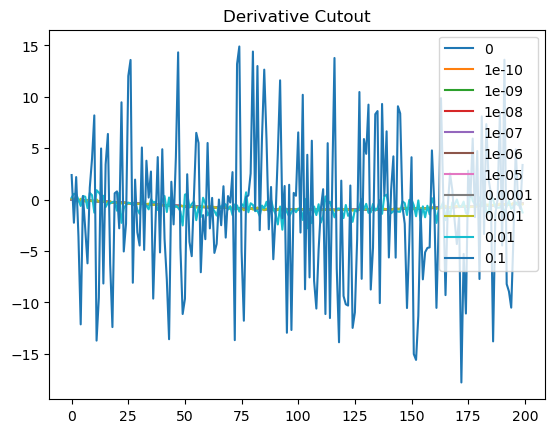

In [133]:
M=infinity_norm(uxxx)
noise_levels = [0]+[10**(-10+i) for i in range(0,10)]
print("Noise level \t  eps \t \t $max|ux-ux_noise|$ \t bound")
plt.title("Derivative Cutout")
order=2
for target_noise in noise_levels:
    var = target_noise * np.sqrt(np.mean(np.square(u)))
    noise = np.random.normal(0, var, size=u.shape)
    u_noise = u + noise
    ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
    plt.plot(ux_noise[0,:],label=str(target_noise))
    eps = infinity_norm(u_noise-u)
    bound = error_bound(eps,dx,M,order)
    diff = infinity_norm(ux-ux_noise)
    print(f"{target_noise} \t \t  {eps:.4f} \t {diff:.4f} \t \t {bound:.4f}")
plt.legend()
plt.show()

In [134]:
M=infinity_norm(uxxx)
number_noise=10 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t  eps \t \t|ux-ux_noise| \t bound")
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=False)._differentiate(u_noise, dx)
        eps = infinity_norm(u_noise-u)
        bound = error_bound(eps,dx,M,order)
        diff = infinity_norm(ux-ux_noise)
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t \t  {eps:.3f} \t {diff:.4f} \t {bound:.4f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|ux-ux_noise| 	 bound
1
	 0	 	  0.000 	 0.0126 	 0.0126
	 1e-10	 	  0.000 	 0.0126 	 0.0126
	 1e-09	 	  0.000 	 0.0126 	 0.0126
	 1e-08	 	  0.000 	 0.0126 	 0.0126
	 1e-07	 	  0.000 	 0.0126 	 0.0126
	 1e-06	 	  0.000 	 0.0127 	 0.0128
	 1e-05	 	  0.000 	 0.0140 	 0.0154
	 0.0001	 	  0.000 	 0.0269 	 0.0364
	 0.001	 	  0.003 	 0.1762 	 0.2427
	 0.01	 	  0.033 	 1.5172 	 2.6552
2
	 0	 	  0.000 	 0.0002 	 0.0042
	 1e-10	 	  0.000 	 0.0002 	 0.0042
	 1e-09	 	  0.000 	 0.0002 	 0.0042
	 1e-08	 	  0.000 	 0.0002 	 0.0042
	 1e-07	 	  0.000 	 0.0002 	 0.0042
	 1e-06	 	  0.000 	 0.0003 	 0.0043
	 1e-05	 	  0.000 	 0.0023 	 0.0054
	 0.0001	 	  0.000 	 0.0211 	 0.0165
	 0.001	 	  0.003 	 0.2039 	 0.1253
	 0.01	 	  0.031 	 2.4862 	 1.2355
3
	 0	 	  0.000 	 0.0000 	 0.0063
	 1e-10	 	  0.000 	 0.0000 	 0.0063
	 1e-09	 	  0.000 	 0.0000 	 0.0063
	 1e-08	 	  0.000 	 0.0000 	 0.0063
	 1e-07	 	  0.000 	 0.0000 	 0.0064
	 1e-06	 	  0.000 	 0.0004 	 0.0071
	 1e-05	 	  0.000 

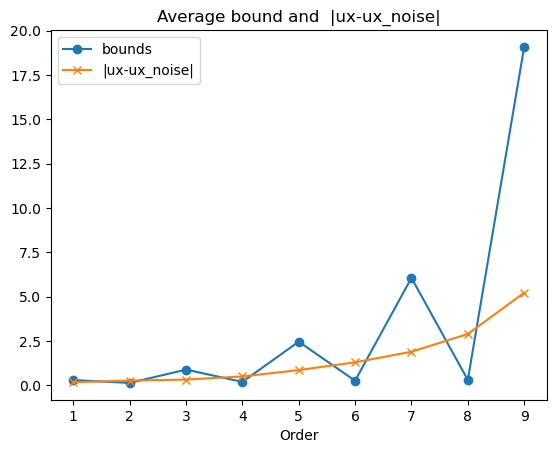

In [135]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|ux-ux_noise|')
plt.legend()

#### Without boundary values

In [136]:
M=infinity_norm(uxxx)
number_noise=8 #<=10
noise_levels = [0]+[10**(-10+i) for i in range(0,number_noise-1)]
orders=range(1,10,1)
print("Order \t Noise level \t  eps \t \t|ux-ux_noise| \t bound")
diff_list = []
bound_list = []
for order in orders:
    print(f"{order}")
    avg_diff=0
    avg_bound=0
    for target_noise in noise_levels:
        var = target_noise * np.sqrt(np.mean(np.square(u)))
        noise = np.random.normal(0, var, size=u.shape)
        u_noise = u + noise
        ux_noise = ps.FiniteDifference(order=order,d=1, axis=0, drop_endpoints=True)._differentiate(u_noise, dx)
        row_mask = ~np.isnan(ux_noise).all(axis=1)
        col_mask = ~np.isnan(ux_noise).all(axis=0)
        eps = infinity_norm(u_noise[row_mask][:, col_mask]-u[row_mask][:, col_mask])
        bound = error_bound(eps,dx,M,order)
        diff = infinity_norm(ux[row_mask][:, col_mask]-ux_noise[row_mask][:, col_mask])
        avg_bound+=bound
        avg_diff+=diff
        print(f"\t {target_noise}\t \t  {eps:.3f} \t {diff:.4f} \t {bound:.4f}")
    avg_bound/=number_noise
    avg_diff/=number_noise
    bound_list.append(avg_bound)
    diff_list.append(avg_diff)

Order 	 Noise level 	  eps 	 	|ux-ux_noise| 	 bound
1
	 0	 	  0.000 	 0.0126 	 0.0126
	 1e-10	 	  0.000 	 0.0126 	 0.0126
	 1e-09	 	  0.000 	 0.0126 	 0.0126
	 1e-08	 	  0.000 	 0.0126 	 0.0126
	 1e-07	 	  0.000 	 0.0126 	 0.0126
	 1e-06	 	  0.000 	 0.0127 	 0.0128
	 1e-05	 	  0.000 	 0.0139 	 0.0150
	 0.0001	 	  0.000 	 0.0304 	 0.0372
2
	 0	 	  0.000 	 0.0001 	 0.0042
	 1e-10	 	  0.000 	 0.0001 	 0.0042
	 1e-09	 	  0.000 	 0.0001 	 0.0042
	 1e-08	 	  0.000 	 0.0001 	 0.0042
	 1e-07	 	  0.000 	 0.0001 	 0.0042
	 1e-06	 	  0.000 	 0.0002 	 0.0043
	 1e-05	 	  0.000 	 0.0009 	 0.0054
	 0.0001	 	  0.000 	 0.0082 	 0.0168
3
	 0	 	  0.000 	 0.0000 	 0.0063
	 1e-10	 	  0.000 	 0.0000 	 0.0063
	 1e-09	 	  0.000 	 0.0000 	 0.0063
	 1e-08	 	  0.000 	 0.0000 	 0.0063
	 1e-07	 	  0.000 	 0.0000 	 0.0064
	 1e-06	 	  0.000 	 0.0001 	 0.0070
	 1e-05	 	  0.000 	 0.0013 	 0.0141
	 0.0001	 	  0.000 	 0.0149 	 0.0852
4
	 0	 	  0.000 	 0.0000 	 0.0008
	 1e-10	 	  0.000 	 0.0000 	 0.0008
	 1e-09	 	  0.000

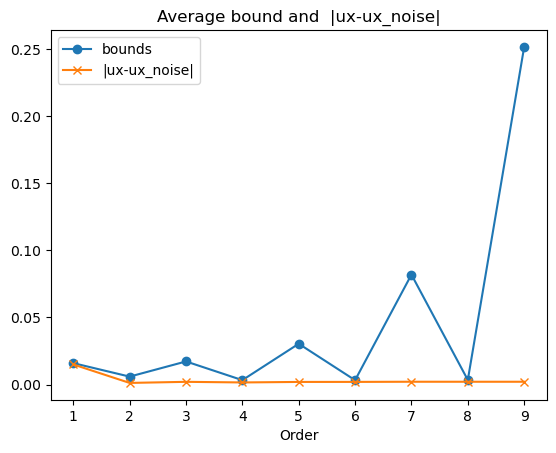

In [137]:
plt.title("Average bound and  |ux-ux_noise|")
plt.xlabel("Order")
plt.plot(orders,bound_list, marker='o',label='bounds')
plt.plot(orders,diff_list,marker='x',label='|ux-ux_noise|')
plt.legend()